## Load Data and Libraries


In [17]:
# load libraries
import os
import gc
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


# import metrics, random forest, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, classification_report, recall_score,precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, PrecisionRecallDisplay, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance



In [2]:
# load custom functions
from models_util import ml_helper as mlh

In [3]:
# load data
scbc = pd.read_csv(os.getcwd() + "\\data\\features_protein\\scbc_protein_features_db.csv", index_col=0)
# abms = pd.read_csv(os.getcwd() + "\\data\\features_protein\\abms_protein_features_db.csv")

In [ ]:
# data and seed as global parameteters
data_type = "SCBC" # either SCBC or ABMS 
classifier_type = "Protein" # protein or 'Proteoform' classifiers
analysis_type =  "Proteoform" # either "Proteoform" or "Sims"  
data = scbc
seed = 569

# drop columns unecessary for classication when splitting X and y 
drop_cols = ["Var1", "Var2", "db"]

## Tuned RF Classifier and Feature Importance (one seed)

In [21]:

top10 = ['SCBC_umap_euc',
 'SCBC_umap_man',
 'SCBC_vae_cor_spear',
 'SCBC_vae_cor_pears',
 'SCBC_vae_cos',
 'SCBC_raw_cor_spear',
 'SCBC_raw_cor_pears',
 'SCBC_raw_man',
 'SCBC_vae_std_dif',
 'SCBC_raw_std_dif']

In [22]:

# raw_cols = scbc.loc[:,~scbc.columns.str.contains("raw")].drop(columns=drop_cols).columns.to_list()
# raw_cols = scbc.loc[:,scbc.columns.str.contains("raw")].columns.to_list()
# my_selection = ["SCBC_umap_euc", "SCBC_vae_cor_pears", "SCBC_raw_cor_pears","SCBC_raw_man","SCBC_vae_cos","SCBC_raw_std_dif","SCBC_umap_man" ]


data = data
seed = seed
selected_cols = top10
scale_data = False
imbalance_factor = None

# sample from the data and undersample the negative class by random shuffling
pos_df = data[data["db"] == 1]
neg_df = data[data["db"] == 0]

if imbalance_factor is not None:
    neg_df = neg_df.sample(n=pos_df.shape[0]*imbalance_factor, random_state=seed)
else:
    neg_df = neg_df.sample(n=pos_df.shape[0], random_state=seed) # 1 to 1 ratio via undersampling 

data_sample = pd.concat([pos_df, neg_df])
del pos_df, neg_df

# shuffle the data
data_sample = data_sample.sample(frac=1, random_state=seed)

# subset columns of data df based on regex
if selected_cols is not None:
    X_df = data_sample[selected_cols]
    X = data_sample[selected_cols]
else:
    X_df = data_sample.drop(columns=drop_cols)
    X = data_sample.drop(columns=drop_cols)

y = data_sample["db"]

# scale the data and create a df again
if scale_data is True:
    X = StandardScaler().fit_transform(X)
    X = pd.DataFrame(X, columns=X_df.columns)



# split train-test sets from this seed 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
del X,y,X_df
gc.collect()

# here we deal with imbalance if applied
if imbalance_factor is not None:
    print(f"Operating smote to minority class with a factor of {imbalance_factor}")
    smote = SMOTE(random_state=seed)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    print("Class distribution after SMOTE:")
    print(pd.Series(y_train).value_counts())
else:
    print("Classifier operates on undersample data")
cv = StratifiedKFold

# train a randomforest classifier, set max features to 0.5
rf = RandomForestClassifier(n_estimators=250,
                            max_features=0.5, 
                            criterion="entropy",
                            random_state=seed,
                            min_samples_leaf=1,
                            class_weight="balanced",
                            n_jobs=6)
rf.fit(X_train, y_train)
rf.feature_importances_

y_predprob = rf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_predprob))

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print(rf.feature_names_in_)

Classifier operates on undersample data
0.835504823172695
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      3344
           1       0.76      0.75      0.75      3388

    accuracy                           0.76      6732
   macro avg       0.76      0.76      0.76      6732
weighted avg       0.76      0.76      0.76      6732

['SCBC_umap_euc' 'SCBC_umap_man' 'SCBC_vae_cor_spear' 'SCBC_vae_cor_pears'
 'SCBC_vae_cos' 'SCBC_raw_cor_spear' 'SCBC_raw_cor_pears' 'SCBC_raw_man'
 'SCBC_vae_std_dif' 'SCBC_raw_std_dif']


In [23]:
# feature importance using permutation
start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=7
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_test.columns.to_list())

Elapsed time to compute the importances: 13.455 seconds


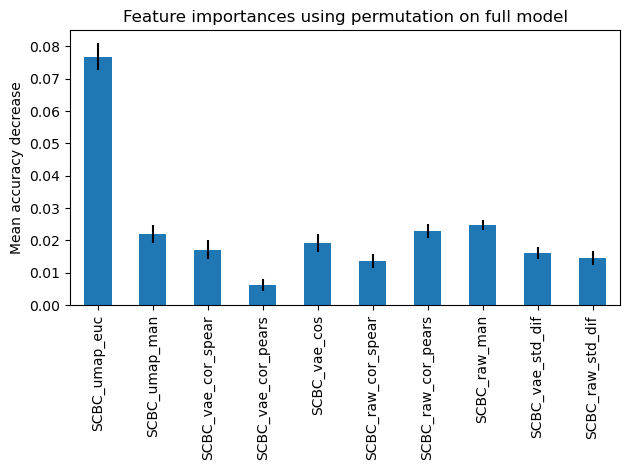

In [24]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [25]:
importance_df = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=["importance"])
importance_df = importance_df.sort_values(by="importance", ascending=False)
# feature_list_imp = list(importance_df.head(10).index)
importance_df
# cols = importance_df.head(10).index.to_list()
# list(cols)

,importance
SCBC_umap_euc,0.186361
SCBC_umap_man,0.140012
SCBC_vae_cor_spear,0.095374
SCBC_raw_cor_spear,0.086790
SCBC_raw_cor_pears,0.085931
SCBC_raw_man,0.085618
SCBC_vae_std_dif,0.082669
SCBC_vae_cos,0.080470
SCBC_raw_std_dif,0.080417
SCBC_vae_cor_pears,0.076359


## Probability Threshold of Classifier (FDR < 0.05)
- Based on the test set I will find the threshold usin a custom bisection search algorith with tolerance of 0.005.
- It starts with a p threshold of 0.5.
- Using a nested function, it computes the FPR, TPR, Recall as well as plot the confusion matrix in that threshold.
- Next, given a FDR tolerance it computes the difference between the desired FRD threshold and the actual FDR.
- It changes the minimum or maximum value and performs a new iteration of a bisection search. 

Iteration 0: threshold=0.7500, FDR=0.1258, TPR=0.4368, FPR=0.0637
Iteration 1: threshold=0.8750, FDR=0.0850, TPR=0.2574, FPR=0.0242
Iteration 2: threshold=0.8125, FDR=0.1051, TPR=0.3442, FPR=0.0410
Iteration 3: threshold=0.8438, FDR=0.0985, TPR=0.3052, FPR=0.0338
Iteration 4: threshold=0.8281, FDR=0.1009, TPR=0.3235, FPR=0.0368
Iteration 5: threshold=0.8203, FDR=0.1018, TPR=0.3332, FPR=0.0383
Iteration 6: threshold=0.8164, FDR=0.1017, TPR=0.3388, FPR=0.0389

Optimal threshold found: 0.816
TPR: 0.339, FPR: 0.039, FDR: 0.102


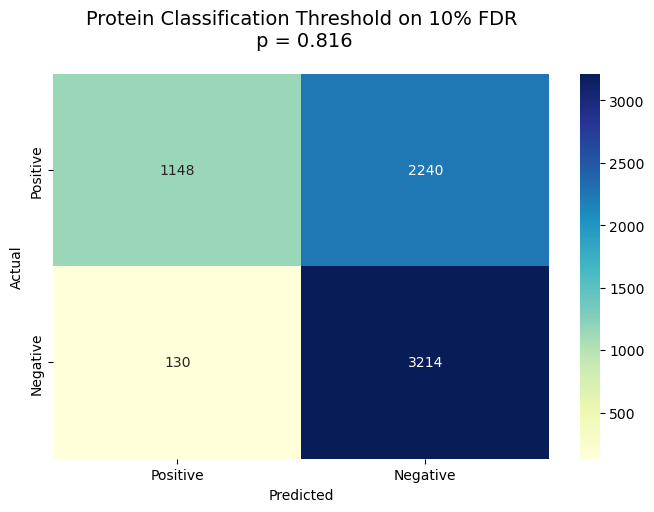

In [26]:
mlh.get_probthreshold(y_test,
                      y_predprob,
                      classifier_type=classifier_type,
                      target_FDR=0.10,
                      fdr_tol=0.005,
                      tol=0.005,
                      max_iter=50)

Iteration 0: threshold=0.7500, FDR=0.1258, TPR=0.4368, FPR=0.0637
Iteration 1: threshold=0.8750, FDR=0.0850, TPR=0.2574, FPR=0.0242
Iteration 2: threshold=0.9375, FDR=0.0472, TPR=0.1609, FPR=0.0081
Iteration 3: threshold=0.9062, FDR=0.0709, TPR=0.2128, FPR=0.0164
Iteration 4: threshold=0.9219, FDR=0.0651, TPR=0.1865, FPR=0.0132
Iteration 5: threshold=0.9297, FDR=0.0575, TPR=0.1741, FPR=0.0108
Iteration 6: threshold=0.9336, FDR=0.0565, TPR=0.1677, FPR=0.0102

Optimal threshold found: 0.938
TPR: 0.161, FPR: 0.008, FDR: 0.047


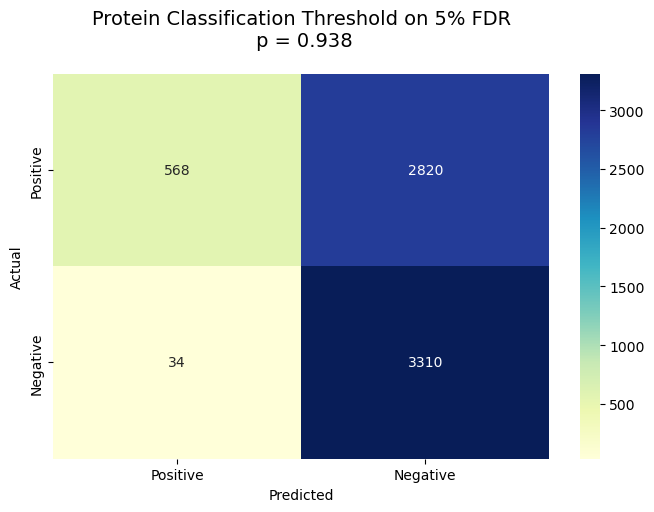

In [27]:
mlh.get_probthreshold(y_test,
                      y_predprob,
                      classifier_type=classifier_type,
                      target_FDR=0.05,
                      fdr_tol=0.005,
                      tol=0.005,
                      max_iter=50)

In [11]:
mlh.compute_metrics(y_test, y_predprob, threshold=0.840)

(array([[1012, 2376],
        [ 114, 3230]], dtype=int64),
 0.2987012987012987,
 0.03409090909090909,
 0.10124333925399645)

## Classification of the Whole Protein Table
- The next steo is to use the randomforest classifier rf to predict the protein-protein interractions or proteoform-proteoform interractions.
- I will also use the probability that corresponds to the desired threshold 

### Load Whole Table

In [ ]:
if classifier_type == "Protein":
    if data_type == "SCBC":
        # load subcell matrix with same features as those the classifier was trained on
        scbc_full = pd.read_csv(os.getcwd() + "\\data\\features_protein\\scbc_protein_features_full.csv", index_col=0)
    elif data_type == "ABMS":
        abms_full = pd.read_csv(os.getcwd() + "\\data\\features_protein\\abms_protein_features_full.csv", index_col=0)

elif classifier_type == "Proteoform" & analysis_type == "Proteoform":
    if data_type == "SCBC":
        # load subcell matrix with same features as those the classifier was trained on
        scbc_full = pd.read_csv(os.getcwd() + "\\data\\features_proteoforms\\scbc_proteoform_features_full.csv", index_col=0)
    elif data_type == "ABMS":
        abms_full = pd.read_csv(os.getcwd() + "\\data\\features_proteoforms\\abms_proteoform_features_full.csv", index_col=0)

elif classifier_type == "Proteoform" & analysis_type == "Proteoform":
    if data_type == "SCBC":
        # load subcell matrix with same features as those the classifier was trained on
        scbc_full = pd.read_csv(os.getcwd() + "\\data\\features_sim\\scbc_sims_features_full.csv", index_col=0)
    elif data_type == "ABMS":
        abms_full = pd.read_csv(os.getcwd() + "\\data\\features_sim\\abms_sims_features_full.csv", index_col=0)        
else:
    raise RuntimeError("Specify classifier_type as either Protein or Proteoform")

## Comparison of the Raw vs Embedding Classifier in a CV-fold 

In [117]:
# stratified fold to get indices
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# choose the features 
X_raw = data_sample.loc[:,data_sample.columns.str.contains("raw")]
X_vae = data_sample.drop(columns=drop_cols)
y = data_sample["db"]

models = {
    "RF-raw": X_raw,
    "RF-vae": X_vae,
}

# Common set of FPR and Recall Points - will interpolate FPR and Precision in each fold 
mean_fpr = np.linspace(0, 1, 100)
mean_recall_grid = np.linspace(0, 1, 100)


# store ROC
roc_data = {}

for model_name, X_model in models.items():
    tprs = []
    aucs = []

    pr_prec = []
    pr_auc = []
    classifier = RandomForestClassifier(n_estimators=200,
                                            max_features=0.4,
                                            criterion="entropy",
                                            random_state=seed,
                                            min_samples_leaf=1,
                                            n_jobs=7)
    
    for fold , (train_idx, test_idx) in enumerate(cv.split(X_model,y)):

        # Train and get probability scores
        classifier.fit(X_model.iloc[train_idx], y.iloc[train_idx])
        y_pred = classifier.predict_proba(X_model.iloc[test_idx])[:, 1]


        ## ROC METRICS ##
        fpr, tpr, thresholds = roc_curve(y.iloc[test_idx], y_pred)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)        

        # at this point i want to adjust / interpolate tpr and fpr (how they correspond to each other)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0 # start is fixed at zero 
        tprs.append(interp_tpr)
        

        ## PR METRICS ##
        precision, recall, _ = precision_recall_curve(y.iloc[test_idx], y_pred)
        # PR is in reverse order
        precision = precision[::-1]
        recall = recall[::-1]

        # Interpolation.
        interp_precision = np.interp(mean_recall_grid, recall, precision)
        pr_prec.append(interp_precision)

        # Compute PR AUC by integrating (using recall as x-axis).
        fold_pr_auc = auc(recall, precision)
        pr_auc.append(fold_pr_auc)

        # if fold > 2:
        #     break

    # outside of second loop

    # calculate averages and stds for all folds per model 
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # make sure the end is fixed at 1.0 as is FPR 
    std_tpr = np.std(tprs, axis=0)
    # calculate auc score for all folds per model 
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Compute CI and std versions for ROC
    tprs_lower = np.percentile(tprs, 2.5, axis=0)
    tprs_upper = np.percentile(tprs, 97.5, axis=0)
    tprs_stdup = np.minimum(mean_tpr + 1.96*(std_tpr/np.sqrt(10)),1)
    tprs_stdown = np.maximum(mean_tpr - 1.96*(std_tpr/np.sqrt(10)),0)

    # aggregate the PR metrics 
    mean_precision = np.mean(pr_prec, axis=0)
    std_precision = np.std(pr_prec, axis=0)
    mean_pr_auc = auc(mean_recall_grid, mean_precision)
    std_pr_auc = np.std(pr_auc)
    pr_prec_lower = np.percentile(pr_prec, 2.5, axis=0)
    pr_prec_upper = np.percentile(pr_prec, 97.5, axis=0)
    pr_prec_stdup = np.minimum(mean_precision + 1.96 * (std_precision / np.sqrt(10)), 1)
    pr_prec_stdown = np.maximum(mean_precision - 1.96 * (std_precision / np.sqrt(10)), 0)
    
        
    roc_data[model_name] = {
            "mean_fpr": mean_fpr,
            "mean_tpr": mean_tpr,
            "mean_auc": mean_auc,
            "std_auc": std_auc,

            "tprs_lower": tprs_lower,
            "tprs_upper": tprs_upper,
            "tprs_stdup": tprs_stdup,
            "tprs_stdown":tprs_stdown,

            "mean_rec": mean_recall_grid,
            "mean_prec": mean_precision,
            "mean_pr_auc": mean_pr_auc,
            "std_pr_auc": std_pr_auc,
            
            "pr_prec_lower": pr_prec_lower,
            "pr_prec_upper": pr_prec_upper,
            "pr_prec_stdup": pr_prec_stdup,
            "pr_prec_stdown": pr_prec_stdown,
        }


In [144]:
# pd.DataFrame(roc_data["RF-raw"])

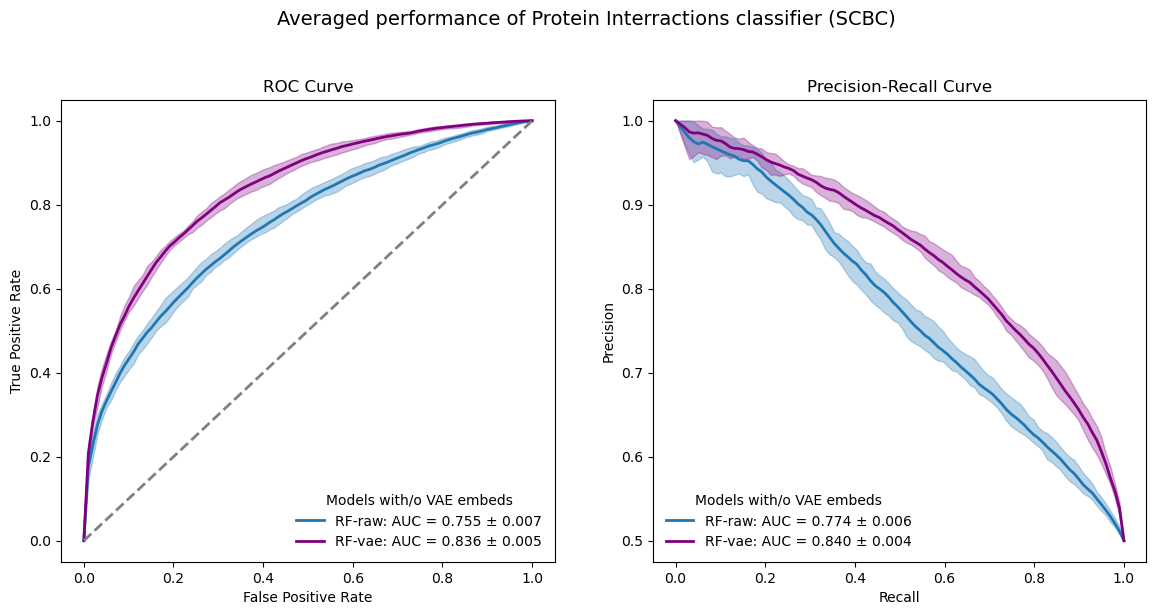

In [ ]:
# Plot the mean ROC curves with 95% confidence intervals for both models
fig, (axleft, axright) = plt.subplots(1,2,figsize=(14, 6))
colorlist = ['tab:blue', 'purple']

for num, (model_name, rd) in enumerate(roc_data.items()):
    axleft.plot(rd["mean_fpr"], rd["mean_tpr"],
             lw=2,
             color=colorlist[num],
             label=f'{model_name}: AUC = {rd["mean_auc"]:.3f} ± {rd["std_auc"]:.3f}')
    axleft.fill_between(rd["mean_fpr"], rd["tprs_lower"], rd["tprs_upper"], alpha=0.3, color=colorlist[num])

    axright.plot(rd["mean_rec"], rd["mean_prec"],
             lw=2,
             color=colorlist[num],
             label=f'{model_name}: AUC = {rd["mean_pr_auc"]:.3f} ± {rd["std_pr_auc"]:.3f}')
    axright.fill_between(rd["mean_rec"], rd["pr_prec_lower"], rd["pr_prec_upper"], alpha=0.3, color=colorlist[num])

# Plot the chance line for reference
# Set labels and titles for ROC subplot.
axleft.set_xlabel("False Positive Rate")
axleft.set_ylabel("True Positive Rate")
axleft.set_title("ROC Curve")
axleft.legend(title="Models with/o VAE embeds", loc="lower right",frameon=False)
axleft.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)


# Set labels and title for PR subplot.
axright.set_xlabel("Recall")
axright.set_ylabel("Precision")
axright.set_title("Precision-Recall Curve")
axright.legend(title="Models with/o VAE embeds", loc="lower left", frameon=False)
plt.suptitle(f"Averaged performance of {classifier_type} Interractions classifier ({data_type})",fontsize=14, y=1.03)
plt.show()